In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### Arquivos já estão divididos em treino, validação e teste.

In [ ]:
src_path1 = '/content/gdrive/MyDrive/TrabalhoFinal_CleanDataset'
train_path = os.path.join(src_path1, 'train_v2')
train_path_emp = os.path.join(train_path, 'empresas')
train_path_Nemp = os.path.join(train_path, 'nao_empresas')

#src_path = '/content/gdrive/MyDrive/619_ProjetoFinal/Dados_ProjetoFinal/split_train_val_test'
src_path = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/split_train_val_test'
val_path = os.path.join(src_path, 'val')
test_path = os.path.join(src_path, 'test')

val_path_emp = os.path.join(val_path, 'imagens_empresas')
val_path_Nemp = os.path.join(val_path, 'imagens_nao_empresas')

test_path_emp = os.path.join(test_path, 'imagens_empresas')
test_path_Nemp = os.path.join(test_path, 'imagens_nao_empresas')

In [ ]:
print('Número de imagens de empresas (treinamento):', len(os.listdir(train_path_emp)))
print('Número de imagens de não empresas (treinamento):', len(os.listdir(train_path_Nemp)))
print('Número de imagens de empresas (validacao):', len(os.listdir(val_path_emp)))
print('Número de imagens de não empresas (validacao):', len(os.listdir(val_path_Nemp)))
print('Número de imagens de empresas (teste):', len(os.listdir(test_path_emp)))
print('Número de imagens de não empresas (teste):', len(os.listdir(test_path_Nemp)))

Número de imagens de empresas (treinamento): 2689
Número de imagens de não empresas (treinamento): 3849
Número de imagens de empresas (validacao): 909
Número de imagens de não empresas (validacao): 1291
Número de imagens de empresas (teste): 910
Número de imagens de não empresas (teste): 1292


#### Imprimindo algumas imagens usadas no treino:

In [ ]:
numeroFiguras = 4

arrImagEmp = os.listdir(train_path_emp)
arrImagEmp = random.sample(arrImagEmp, numeroFiguras)
print(arrImagEmp)

arrImagNEmp = os.listdir(train_path_Nemp)
arrImagNEmp = random.sample(arrImagNEmp, numeroFiguras)
print(arrImagNEmp)

['1861.jpg', '1317.jpg', '2789.jpg', '1815.jpg']
['6976.jpg', '2576.jpg', '5155.jpg', '296.jpg']


Imagens de empresas:


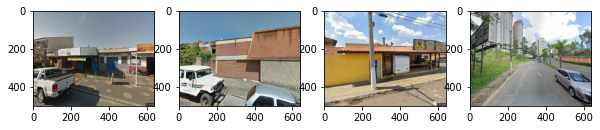

In [ ]:
fig = plt.figure(figsize=(10,5))

print("Imagens de empresas:")
for i in range(4):
    # Imagens de empresas:
    plt.subplot(240 + 1 + i)
    img = plt.imread(os.path.join(train_path_emp,arrImagEmp[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

Imagens de não empresas:


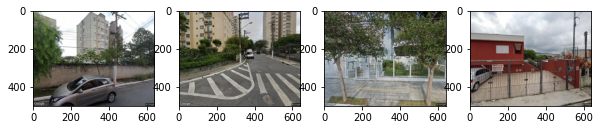

In [ ]:
fig = plt.figure(figsize=(10,5))

print("Imagens de não empresas:")
for i in range(4):
    # Imagens de não empresas:
    z = i + 4
    plt.subplot(240 + 1 + z)
    img = plt.imread(os.path.join(train_path_Nemp,arrImagNEmp[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

### Gerando dados de treino e validação.

In [ ]:
#Leitura e preprocessamento das imagens
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(25, 5))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8((img+1)*127.5), interpolation='nearest')
    plt.show()

## Modelo com Inception V3

#### Preprocessamento de Dados.

In [ ]:
train_datagen1 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

## flow_from_directory ##
train_generator1 = train_datagen1.flow_from_directory(directory=train_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=True)
batch_X_proc, batch_Y_proc = train_generator1.next()

validation_generator1 = train_datagen1.flow_from_directory(directory=val_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=False)
batch_val_X_proc, batch_val_Y_proc = validation_generator1.next()

print(batch_X_proc.shape, batch_Y_proc.shape)

Found 6538 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
(32, 299, 299, 3) (32, 2)


Imagens após preprocessamento


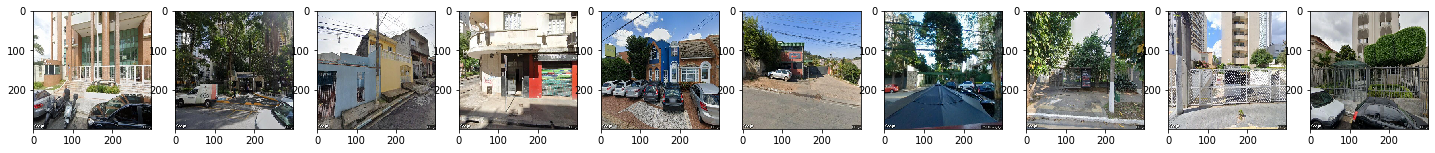

(None, None)

In [ ]:
print("Imagens após preprocessamento"), plotImages(batch_X_proc[:10], 1, 10)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#Pesos para Balanceamento das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator1.labels), y=train_generator1.labels)
train_class_weights = dict(enumerate(class_weights))
print('train_class_weights: ', train_class_weights)

train_class_weights:  {0: 1.2156935663815545, 1: 0.8493115094829826}


####Gerando o modelo.

In [ ]:
#Modelo com camadas pré-treinadas congeladas
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in model.layers:
    layer.trainable = False
model1 = tf.keras.Sequential([model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(2, activation='softmax')])
model1.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


####Treinando e avaliando o modelo.

In [ ]:
#Instancia um otimizador SGD e compila o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

In [ ]:
#Treinamento
history1 = model1.fit(train_generator1, epochs=25, batch_size=32, validation_data=validation_generator1, class_weight=train_class_weights)

Epoch 1/25
205/205 [==============================] - 3042s 15s/step - loss: 0.4952 - auc: 0.8403 - accuracy: 0.7539 - val_loss: 0.4204 - val_auc: 0.8909 - val_accuracy: 0.8123
Epoch 2/25
205/205 [==============================] - 61s 296ms/step - loss: 0.4174 - auc: 0.8928 - accuracy: 0.8100 - val_loss: 0.3930 - val_auc: 0.9052 - val_accuracy: 0.8259
Epoch 3/25
205/205 [==============================] - 61s 295ms/step - loss: 0.3994 - auc: 0.9026 - accuracy: 0.8168 - val_loss: 0.3815 - val_auc: 0.9106 - val_accuracy: 0.8323
Epoch 4/25
205/205 [==============================] - 61s 297ms/step - loss: 0.3897 - auc: 0.9074 - accuracy: 0.8267 - val_loss: 0.3782 - val_auc: 0.9122 - val_accuracy: 0.8368
Epoch 5/25
205/205 [==============================] - 60s 295ms/step - loss: 0.3833 - auc: 0.9112 - accuracy: 0.8296 - val_loss: 0.4115 - val_auc: 0.8939 - val_accuracy: 0.8100
Epoch 6/25
205/205 [==============================] - 60s 294ms/step - loss: 0.3780 - auc: 0.9135 - accuracy: 0.831

In [ ]:
import h5py
# save model and architecture to single file
model1.save("/content/gdrive/MyDrive/INF 0619-010 - Trabalho Final - Zanoni/Modelos/model_InceptionV3_Clean.h5")
print("Saved model to disk")

Saved model to disk


####Resultados do modelo.

69/69 - 15s - loss: 0.3689 - auc: 0.9163 - accuracy: 0.8373 - 15s/epoch - 221ms/step


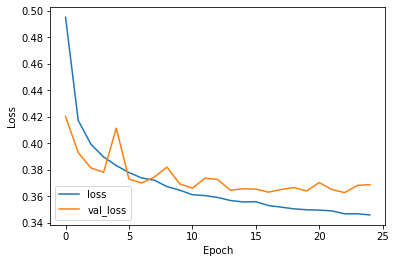

In [ ]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

loss, auc, acc = model1.evaluate(validation_generator1, verbose=2)

####Acurácia balanceada.



In [ ]:
#Reseta o gerador para gerar os dados usados no nosso predict.
validation_generator1.reset()

#Faz a predição à partir dos dados do nosso gerador.
y_pred_sa = model1.predict(validation_generator1)       

In [ ]:
# Converte os valores preditos para números inteiros nos valores de 0 ou 1.
y_pred_int_sa = (y_pred_sa > 0.5).astype(np.int32) 

# A lista acima é formada por listas de tamanho 2 onde nos interessa apenas o segundo item de cada lista, portanto o que fazemos nesse trecho é gerar 
# uma nova lista de inteiros selecionando apenas o 2º item de cada lista presente no y_pred_nn.
y_pred_nn_sa = []
for item in y_pred_int_sa:
    y_pred_nn_sa.append(item[1])

In [ ]:
# Novamente faz o reset do gerador para puxarmos os dados do target.
validation_generator1.reset()

# Gera uma lista com os rótulos de cada imagem.
Y_val = []

while True:
    x,y = validation_generator1.next()
    
    new_list = []
    for item in y:
        new_list.append(item)
        
    Y_val += new_list
    if len(Y_val) > 2200:
        break

In [ ]:
# Acurácia balanceada.
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(validation_generator1.labels, y_pred_nn_sa, sample_weight=None, adjusted=False)

0.8359574919536881

####Matriz de Confusão.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

# Matriz de confusão
cm = confusion_matrix(validation_generator1.classes, y_pred_nn_sa)



Acurácia balanceada: 0.836


Matriz de confusão balanceada


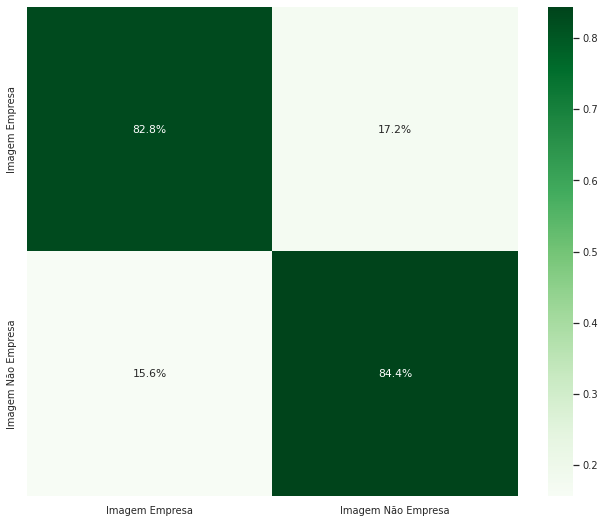

In [ ]:
# Matriz de confusão normalizada
num_classes=2
categories = ['Imagem Empresa', 'Imagem Não Empresa']
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nAcurácia balanceada:", round(balanced_acc,4))

print("\n\nMatriz de confusão balanceada")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=categories, yticklabels=categories, cmap='Greens')

####AUC ROC.

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(validation_generator1.classes, y_pred_sa[:,1], pos_label=1)

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(validation_generator1.classes, y_pred_sa[:,1])
print(auc_score)

0.9151534828153612


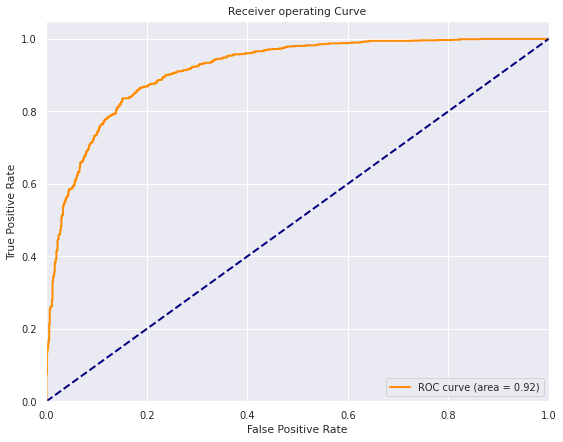

In [ ]:
plt.figure(figsize = (9,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating Curve")
plt.legend(loc="lower right")
plt.show()

## Modelo com Xception

In [ ]:
train_datagen2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

## flow_from_directory ##
train_generator2 = train_datagen2.flow_from_directory(directory=train_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=True)
batch_X_proc, batch_Y_proc = train_generator2.next()

validation_generator2 = train_datagen2.flow_from_directory(directory=val_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=False)
batch_val_X_proc, batch_val_Y_proc = validation_generator2.next()

print(batch_X_proc.shape, batch_Y_proc.shape)

Found 6538 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
(32, 299, 299, 3) (32, 2)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#Pesos para Balanceamento das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator2.labels), y=train_generator2.labels)
train_class_weights = dict(enumerate(class_weights))
print('train_class_weights: ', train_class_weights)

train_class_weights:  {0: 1.2156935663815545, 1: 0.8493115094829826}


In [ ]:
#Modelo com camadas pré-treinadas congeladas
model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in model.layers:
    layer.trainable = False
model2 = tf.keras.Sequential([model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(2, activation='softmax')])
model2.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Instancia um otimizador SGD e compila o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)
model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

In [ ]:
#Treinamento
history2 = model2.fit(train_generator2, epochs=25, batch_size=32, validation_data=validation_generator2, class_weight=train_class_weights)

Epoch 1/25
205/205 [==============================] - 67s 315ms/step - loss: 0.5586 - auc_1: 0.8021 - accuracy: 0.7164 - val_loss: 0.4678 - val_auc_1: 0.8757 - val_accuracy: 0.8014
Epoch 2/25
205/205 [==============================] - 63s 309ms/step - loss: 0.4621 - auc_1: 0.8760 - accuracy: 0.7928 - val_loss: 0.4438 - val_auc_1: 0.8815 - val_accuracy: 0.8009
Epoch 3/25
205/205 [==============================] - 63s 307ms/step - loss: 0.4432 - auc_1: 0.8831 - accuracy: 0.7967 - val_loss: 0.4277 - val_auc_1: 0.8887 - val_accuracy: 0.8100
Epoch 4/25
205/205 [==============================] - 63s 307ms/step - loss: 0.4329 - auc_1: 0.8877 - accuracy: 0.8053 - val_loss: 0.4181 - val_auc_1: 0.8931 - val_accuracy: 0.8173
Epoch 5/25
205/205 [==============================] - 63s 305ms/step - loss: 0.4262 - auc_1: 0.8910 - accuracy: 0.8076 - val_loss: 0.4143 - val_auc_1: 0.8946 - val_accuracy: 0.8177
Epoch 6/25
205/205 [==============================] - 62s 305ms/step - loss: 0.4215 - auc_1: 0.

In [ ]:
import h5py
# serialize weights to HDF5
model2.save("/content/gdrive/MyDrive/INF 0619-010 - Trabalho Final - Zanoni/Modelos/model_Xception_Clean.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


69/69 - 16s - loss: 0.3997 - auc_1: 0.9014 - accuracy: 0.8223 - 16s/epoch - 228ms/step


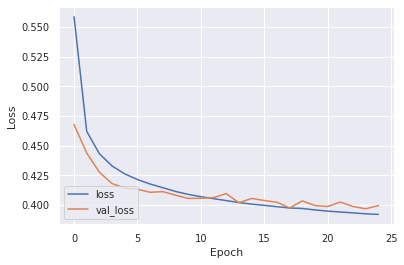

In [ ]:
#Resultado do modelo
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

loss, auc, acc = model2.evaluate(validation_generator2, verbose=2)

In [ ]:
#Acurácia Balanceada

#Reseta o gerador para gerar os dados usados no nosso predict.
validation_generator2.reset()

#Faz a predição à partir dos dados do nosso gerador.
y_pred_sa = model2.predict(validation_generator2)

# Converte os valores preditos para números inteiros nos valores de 0 ou 1.
y_pred_int_sa = (y_pred_sa > 0.5).astype(np.int32) 

# A lista acima é formada por listas de tamanho 2 onde nos interessa apenas o segundo item de cada lista, portanto o que fazemos nesse trecho é gerar 
# uma nova lista de inteiros selecionando apenas o 2º item de cada lista presente no y_pred_nn.
y_pred_nn_sa = []
for item in y_pred_int_sa:
    y_pred_nn_sa.append(item[1])    

In [ ]:
# Novamente faz o reset do gerador para puxarmos os dados do target.
validation_generator2.reset()

# Gera uma lista com os rótulos de cada imagem.
Y_val = []

while True:
    x,y = validation_generator2.next()
    
    new_list = []
    for item in y:
        new_list.append(item)
        
    Y_val += new_list
    if len(Y_val) > 2200:
        break

In [ ]:
# Acurácia balanceada
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(validation_generator2.labels, y_pred_nn_sa, sample_weight=None, adjusted=False)

0.8202470518159484

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

# Matriz de confusão
cm = confusion_matrix(validation_generator2.classes, y_pred_nn_sa)



Acurácia balanceada: 0.8202


Matriz de confusão balanceada


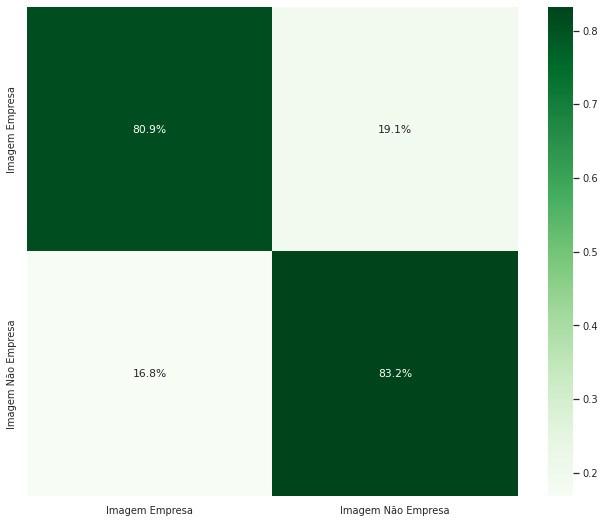

In [ ]:
# Matriz de confusão normalizada
num_classes=2
categories = ['Imagem Empresa', 'Imagem Não Empresa']
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nAcurácia balanceada:", round(balanced_acc,4))

print("\n\nMatriz de confusão balanceada")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=categories, yticklabels=categories, cmap='Greens')

In [ ]:
#AUC-ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(validation_generator2.classes, y_pred_sa[:,1], pos_label=1)

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(validation_generator2.classes, y_pred_sa[:,1])
print(auc_score)

0.8998806154821524


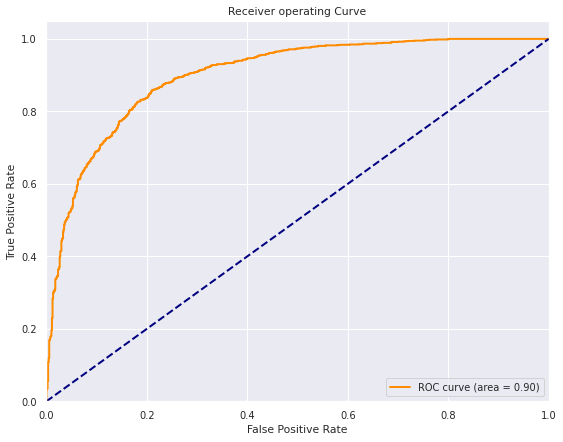

In [ ]:
plt.figure(figsize = (9,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating Curve")
plt.legend(loc="lower right")
plt.show()

## Modelo com  Inception ResNet V2.

In [ ]:
train_datagen3 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

## flow_from_directory ##
train_generator3 = train_datagen3.flow_from_directory(directory=train_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=True)
batch_X_proc, batch_Y_proc = train_generator3.next()

validation_generator3 = train_datagen3.flow_from_directory(directory=val_path, target_size=(299, 299), batch_size=32, class_mode='categorical', shuffle=False)
batch_val_X_proc, batch_val_Y_proc = validation_generator3.next()

print(batch_X_proc.shape, batch_Y_proc.shape)

Found 6538 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
(32, 299, 299, 3) (32, 2)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#Pesos para Balanceamento das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator3.labels), y=train_generator3.labels)
train_class_weights = dict(enumerate(class_weights))
print('train_class_weights: ', train_class_weights)

train_class_weights:  {0: 1.2156935663815545, 1: 0.8493115094829826}


In [ ]:
#Modelo com camadas pré-treinadas congeladas
model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in model.layers:
    layer.trainable = False
model3 = tf.keras.Sequential([model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(2, activation='softmax')])
model3.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
#Instancia um otimizador SGD e compila o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)
model3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

In [ ]:
#Treinamento
history3 = model3.fit(train_generator3, epochs=25, batch_size=32, validation_data=validation_generator3, class_weight=train_class_weights)

Epoch 1/25
205/205 [==============================] - 77s 330ms/step - loss: 0.5225 - auc_2: 0.8194 - accuracy: 0.7337 - val_loss: 0.4345 - val_auc_2: 0.8834 - val_accuracy: 0.8005
Epoch 2/25
205/205 [==============================] - 65s 315ms/step - loss: 0.4468 - auc_2: 0.8768 - accuracy: 0.7961 - val_loss: 0.4281 - val_auc_2: 0.8842 - val_accuracy: 0.7973
Epoch 3/25
205/205 [==============================] - 64s 314ms/step - loss: 0.4314 - auc_2: 0.8853 - accuracy: 0.8036 - val_loss: 0.4223 - val_auc_2: 0.8878 - val_accuracy: 0.8059
Epoch 4/25
205/205 [==============================] - 64s 312ms/step - loss: 0.4232 - auc_2: 0.8907 - accuracy: 0.8106 - val_loss: 0.4099 - val_auc_2: 0.8947 - val_accuracy: 0.8114
Epoch 5/25
205/205 [==============================] - 64s 313ms/step - loss: 0.4165 - auc_2: 0.8947 - accuracy: 0.8143 - val_loss: 0.4251 - val_auc_2: 0.8850 - val_accuracy: 0.8014
Epoch 6/25
205/205 [==============================] - 64s 313ms/step - loss: 0.4130 - auc_2: 0.

In [ ]:
import h5py
# serialize weights to HDF5
model3.save("/content/gdrive/MyDrive/INF 0619-010 - Trabalho Final - Zanoni/Modelos/model_InceptionResNetV2_Clean.h5")
print("Saved model to disk")

Saved model to disk


69/69 - 16s - loss: 0.4015 - auc_2: 0.8988 - accuracy: 0.8123 - 16s/epoch - 237ms/step


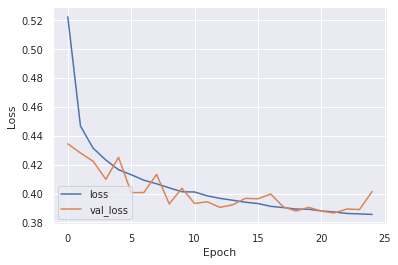

In [ ]:
#Resultado do modelo
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

loss, auc, acc = model3.evaluate(validation_generator3, verbose=2)

In [ ]:
#Acurácia Balanceada

#Reseta o gerador para gerar os dados usados no nosso predict.
validation_generator3.reset()

#Faz a predição à partir dos dados do nosso gerador.
y_pred_sa = model3.predict(validation_generator3)

# Converte os valores preditos para números inteiros nos valores de 0 ou 1.
y_pred_int_sa = (y_pred_sa > 0.5).astype(np.int32) 

# A lista acima é formada por listas de tamanho 2 onde nos interessa apenas o segundo item de cada lista, portanto o que fazemos nesse trecho é gerar 
# uma nova lista de inteiros selecionando apenas o 2º item de cada lista presente no y_pred_nn.
y_pred_nn_sa = []
for item in y_pred_int_sa:
    y_pred_nn_sa.append(item[1])  

In [ ]:
# Novamente faz o reset do gerador para puxarmos os dados do target.
validation_generator3.reset()

# Gera uma lista com os rótulos de cada imagem.
Y_val = []

while True:
    x,y = validation_generator3.next()
    
    new_list = []
    for item in y:
        new_list.append(item)
        
    Y_val += new_list
    if len(Y_val) > 2200:
        break

In [ ]:
# Acurácia balanceada
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(validation_generator3.labels, y_pred_nn_sa, sample_weight=None, adjusted=False)

0.8149816918175163

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

# Matriz de confusão
cm = confusion_matrix(validation_generator3.classes, y_pred_nn_sa)



Acurácia balanceada: 0.815


Matriz de confusão balanceada


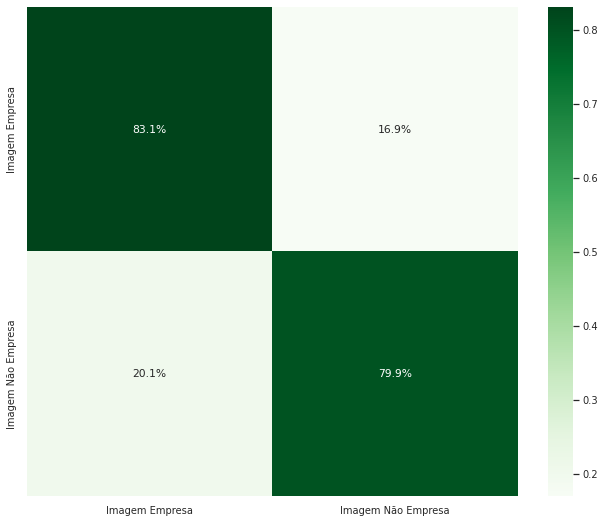

In [ ]:
# Matriz de confusão normalizada
num_classes=2
categories = ['Imagem Empresa', 'Imagem Não Empresa']
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nAcurácia balanceada:", round(balanced_acc,4))

print("\n\nMatriz de confusão balanceada")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=categories, yticklabels=categories, cmap='Greens')

In [ ]:
#AUC-ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(validation_generator3.classes, y_pred_sa[:,1], pos_label=1)

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(validation_generator3.classes, y_pred_sa[:,1])
print(auc_score)

0.9028358296712709


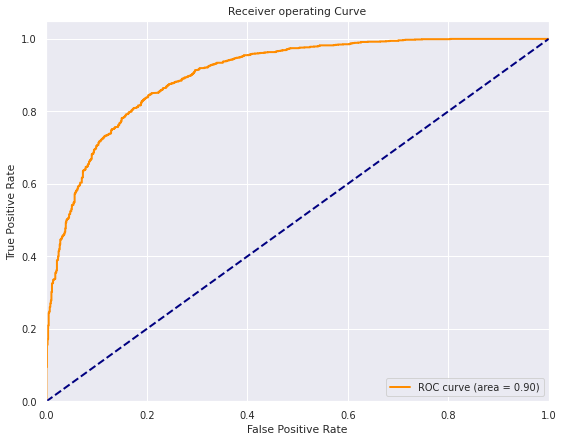

In [ ]:
plt.figure(figsize = (9,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating Curve")
plt.legend(loc="lower right")
plt.show()